# Amazon Bedrock boto3 Setup

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [1]:
# %pip install --no-build-isolation --force-reinstall \
#     "boto3>=1.28.57" \
#     "awscli>=1.29.57" \
#     "botocore>=1.31.57"


This notebook demonstrates invoking Bedrock models directly using the AWS SDK, but for later notebooks in the workshop you'll also need to install other packages.

Here are links for some packages you might not be familiar with:

- [FAISS](https://github.com/facebookresearch/faiss), to store vector embeddings
- [sqlalchemy](https://www.sqlalchemy.org/), SQLAlchemy is the Python SQL toolkit 
- [Pinecone](http://pinecone.io), to store vector embeddings
- [PyPDF](https://pypi.org/project/pypdf/), for handling PDF files
- [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/), for interactive UI widgets in the notebook
- [NeMo-Guardrails](https://github.com/NVIDIA/NeMo-Guardrails) an open-source toolkit for easily adding programmable guardrails to LLM-based conversational systems


### text

In [2]:
# %pip install --quiet \
#     langchain==0.0.309 \
#     "transformers>=4.24,<5" \
#     sqlalchemy -U \
#     "faiss-cpu>=1.7,<2" \
#     "pypdf>=3.8,<4" \
#     pinecone-client \
#     apache-beam \
#     datasets \
#     tiktoken \
#     "ipywidgets>=7,<8" \
#     matplotlib


### agents

In [3]:
# %pip install --quiet \
#     duckduckgo-search  \
#     yfinance  \
#     pandas_datareader  \
#     langchain_experimental \
#     pysqlite3 \
#     google-search-results


### image

In [4]:
# %pip install --quiet "pillow>=9.5,<10"


### Restart Kernel 

In [5]:
# # restart kernel
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")

---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=boto3_bedrock`

In [6]:
import json
filepath = './aws_credentials.json'
file = open(filepath, 'r')
# Open the credentials file with json.load
credentials = json.load(file)

In [7]:
import os
os.environ["AWS_ACCESS_KEY_ID"] = credentials['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"] = credentials['AWS_SECRET_ACCESS_KEY']

In [8]:
import json
import os
import sys

import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

os.environ["AWS_DEFAULT_REGION"] = credentials['AWS_DEFAULT_REGION'] # E.g. "us-east-1"
os.environ["BEDROCK_ASSUME_ROLE"] = credentials['BEDROCK_ASSUME_ROLE'] # E.g. "arn:aws:..."


boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=False
)


Create new client
  Using region: us-east-1
  Using role: arn:aws:iam::715259621071:role/bedrock_role ... successful!
boto3 Bedrock client successfully created!
bedrock(https://bedrock.us-east-1.amazonaws.com)


#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [9]:
boto3_bedrock.list_foundation_models()


{'ResponseMetadata': {'RequestId': 'c797934a-e93d-49fc-9ee4-65772cf15c32',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 03 Dec 2023 03:12:40 GMT',
   'content-type': 'application/json',
   'content-length': '17834',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c797934a-e93d-49fc-9ee4-65772cf15c32'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND']},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0',
   'modelId': 'amazon.titan-image-generator-v1:0',
   'modelName': 'Titan Image Generator G1',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT', 'IMAGE'],
 

### Stability AI Stable Diffusion XL

#### Input

```json
{
    "text_prompts": [
        {"text": "this is where you place your input text"}
    ],
    "cfg_scale": 10,
    "seed": 0,
    "steps": 50
}
```

#### Output

```json
{ 
    "result": "success", 
    "artifacts": [
        {
            "seed": 123, 
            "base64": "<image in base64>",
            "finishReason": "SUCCESS"
        },
        //...
    ]
}
```

---

## Try out the models

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:

In [10]:
bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None)
)


Create new client
  Using region: us-east-1
  Using role: arn:aws:iam::715259621071:role/bedrock_role ... successful!
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


### Stability Stable Diffusion XL

In [11]:
prompt_data = " A blue backpack on a table"
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl"
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAABcGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


**Note:** The output is a [base64 encoded](https://docs.python.org/3/library/base64.html) string of the image data. You can use any image processing library (such as [Pillow](https://pillow.readthedocs.io/en/stable/)) to decode the image as in the example below:

```python
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
```

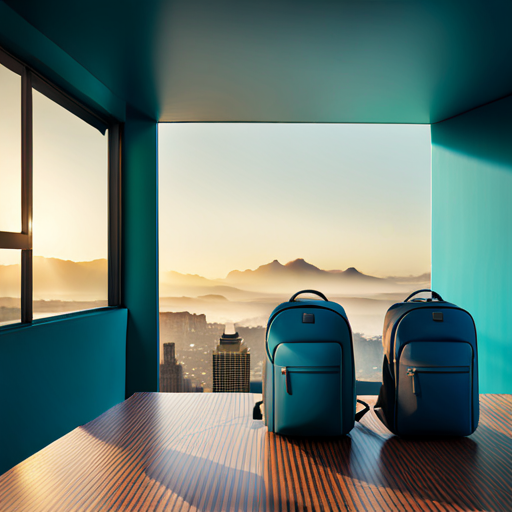

In [12]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image

## Amazon Titan Image Generator

In [13]:
amazon_titan_json = {
    "modelId": "amazon.titan-image-generator-v1:0",
    "contentType": "application/json",
    "accept": "application/json",
    "body": {
        "textToImageParams": {
            "text": "Sunflowers in origami art style"
        },
        "taskType": "TEXT_IMAGE",
        "imageGenerationConfig": {
            "cfgScale": 8,
            "seed": 0,
            "quality": "standard",
            "width": 1024,
            "height": 1024,
            "numberOfImages": 3
        }
    }
}

# Convert the dictionary to a JSON-formatted string and encode it as bytes
amazon_titan_json['body'] = json.dumps(amazon_titan_json['body']).encode('utf-8')

In [14]:
try:
    
    response = bedrock_runtime.invoke_model(
        body=amazon_titan_json['body'], modelId=amazon_titan_json['modelId'], accept=amazon_titan_json['accept'],
        contentType=amazon_titan_json['contentType']
    )
    response_body = json.loads(response.get("body").read())
    print(response.get("ResponseMetadata")["HTTPStatusCode"])

    

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error

200


In [15]:
len(response_body.get("images"))

3

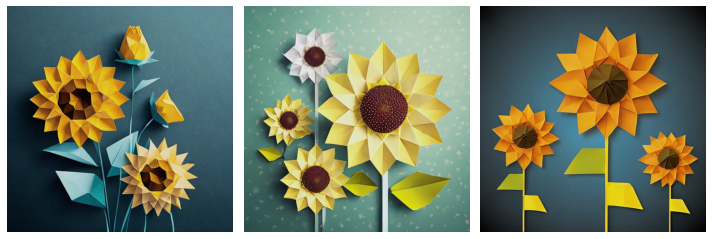

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
num_columns = 3
num_rows = (len(response_body.get("images")) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 8))

axes = axes.flatten()

for i, initial_image_str in enumerate(response_body.get("images")):
    image = Image.open(io.BytesIO(base64.decodebytes(bytes(initial_image_str, "utf-8"))))

    axes[i].imshow(image)
    axes[i].axis('off')  
    
plt.tight_layout()
plt.show()

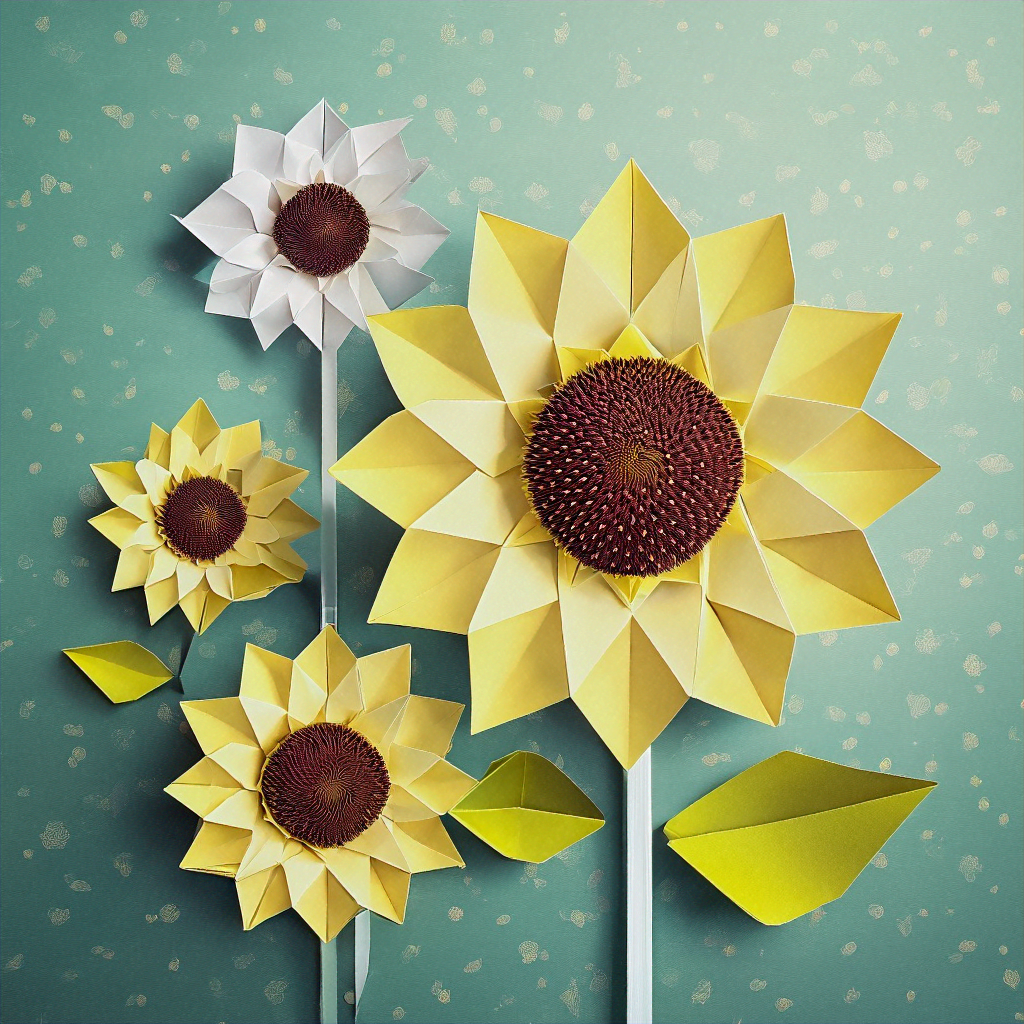

In [24]:
import base64
import io

initial_image_str = response_body.get("images")[1]
image = Image.open(io.BytesIO(base64.decodebytes(bytes(initial_image_str, "utf-8"))))
image

- Generating an Image 
- Creating variations from a base image 
- In painting - editing an image

<!-- ## In painting - Editing an Image  -->

In [18]:
# amazon_titan_json_variation = {
#   "modelId": "amazon.titan-image-generator-v1:0",
#   "contentType": "application/json",
#   "accept": "application/json",
#   "body": { 
#     "inPaintingParams": {
#       "text": "Change the color to blue",
#       "image": initial_image_str,
#       "maskPrompt": "background"
#     }, 
#     "taskType": "INPAINTING", 
#     "imageGenerationConfig": {
#       "quality": "standard",
#       "numberOfImages": 1
#     }
#   }
# }

# # Convert the dictionary to a JSON-formatted string and encode it as bytes
# amazon_titan_json_variation['body'] = json.dumps(amazon_titan_json_variation['body']).encode('utf-8')

## Image Variation

In [25]:
variation_images = [initial_image_str]

In [26]:
amazon_titan_json_variation = {
  "modelId": "amazon.titan-image-generator-v1:0",
  "contentType": "application/json",
  "accept": "application/json",
  "body": { 
    "imageVariationParams": {
      "text": "hdr",
      "images": variation_images,
    }, 
    "taskType": "IMAGE_VARIATION", 
    "imageGenerationConfig": {
      "quality": "premium",
      "numberOfImages": 3,
     "height": 1024,
    "width": 1024,
    "cfgScale": 8.0
    }
  }
}

# Convert the dictionary to a JSON-formatted string and encode it as bytes
amazon_titan_json_variation['body'] = json.dumps(amazon_titan_json_variation['body']).encode('utf-8')

In [27]:
try:
    
    response_variation = bedrock_runtime.invoke_model(
        body=amazon_titan_json_variation['body'], modelId=amazon_titan_json_variation['modelId'], accept=amazon_titan_json_variation['accept'],
        contentType=amazon_titan_json_variation['contentType']
    )
    response_body_variation = json.loads(response_variation.get("body").read())
    print(response.get("ResponseMetadata")["HTTPStatusCode"])

    

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error

200


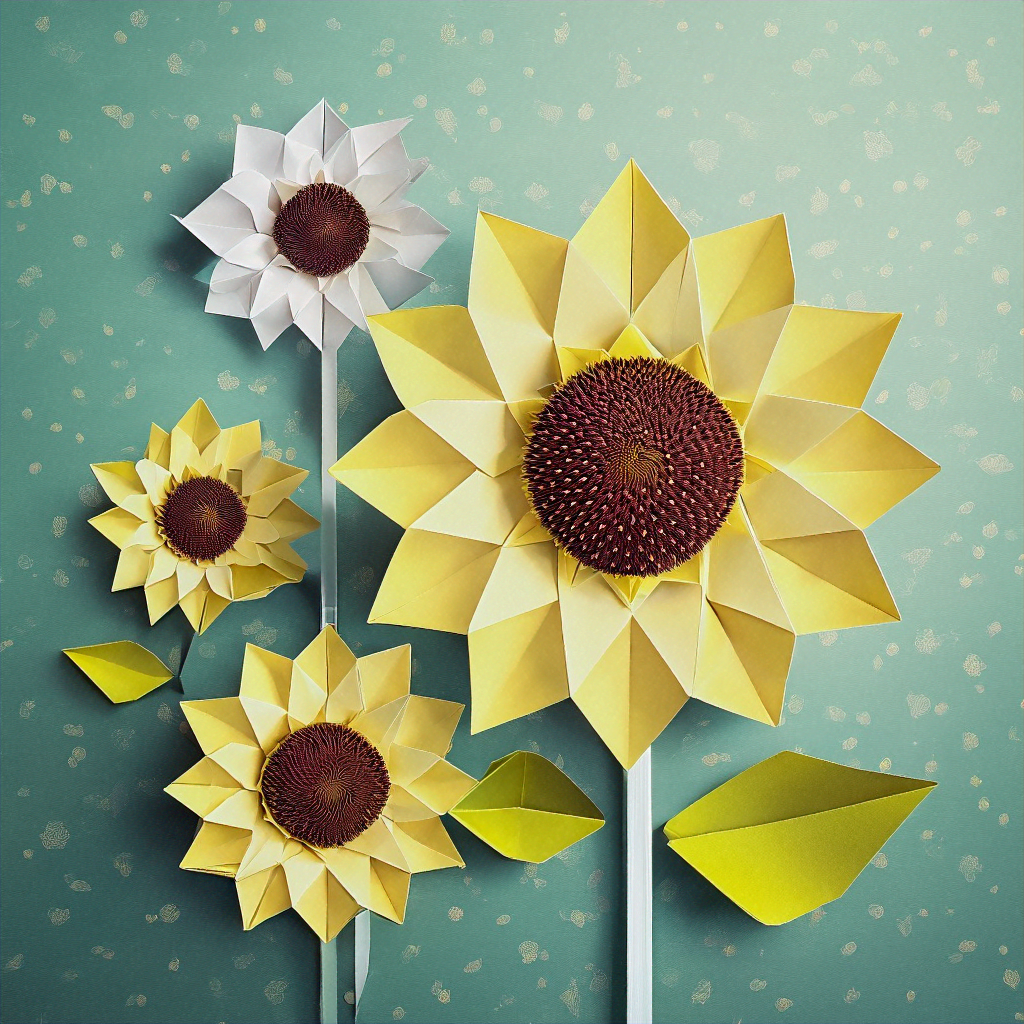

In [28]:
initial_image_str = response_body.get("images")[1]
image = Image.open(io.BytesIO(base64.decodebytes(bytes(initial_image_str, "utf-8"))))
image

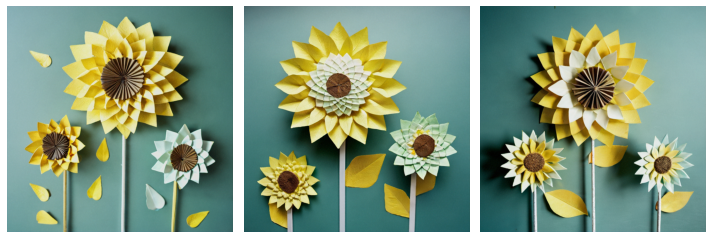

In [29]:
num_columns = 3
num_rows = (len(response_body_variation.get("images")) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 8))

axes = axes.flatten()

for i, initial_image_str in enumerate(response_body_variation.get("images")):
    image = Image.open(io.BytesIO(base64.decodebytes(bytes(initial_image_str, "utf-8"))))
    axes[i].imshow(image)
    axes[i].axis('off')  
    
plt.tight_layout()
plt.show()